## Settings

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")

import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

## Data

In [2]:
protodc2 = GCRCatalogs.load_catalog('proto-dc2_v3.0_redmapper')
protoDC2_v3_redmapper=Table(protodc2.get_quantities(['cluster_id','redshift_true_cluster','halo_mass','richness']))

protoDC2_v3_redmapper.rename_column('redshift_true_cluster', 'redshift_true')
protoDC2_v3_redmapper.rename_column('halo_mass', 'm200c')

dt_halos = protoDC2_v3_redmapper

cut=dt_halos['richness'] > 0
dt_halos = dt_halos[cut]

print(protodc2.get_catalog_info('description'))
print(protodc2.cosmology)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

cluster catalog and member catalog from the redMaPPer cluster finder run on proto-dc2. Red
sequence was fit in the standard way, but centers are on halo centers, i.e. a real halo finding
run was not done.

FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.265, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.0448)


## Bins

Nestas células fazemos um recorte de intervalos de z de largura 0.05 e esses intervalos são colocados em **halos_bin_z**. Depois, pegamos cada *bin* em z e cortamos em intervalos de lnM de largura 0.25. Os bins são colocados em **halos_bin_mz**.

Para cada intervalo em **halos_bin_mz** é calculado lnR médio, z médio e lnM médio e as listas desses valores são colocadas na tabela **halos_mean**.

In [3]:
#z bins:
d = 0.05
z_bins = int((max(z) - min (z)) // d  + 1)

d_m = 0.25
m_bins = int((max(lnM) - min (lnM)) // d_m + 1)

print(f'Number of z bins: {z_bins}.\nNumber of lnM bins: {m_bins}.\nTotal bins: {z_bins * m_bins}.')

Number of z bins: 18.
Number of lnM bins: 8.
Total bins: 144.


In [4]:
# redshift bins
z_0 = 0.0
z_1 = 0.05
halos_bin_z =[]

for i in range(61):
    cut_z = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    halos_bin_z.append(dt_halos[cut_z])
    z_0 = z_0 + 0.05
    z_1 = z_1 + 0.05

# mass bins
label = []
halos_bin_mz =[]
for i in range(61):
    
    lnM_0 = min(lnM)
    lnM_1 = min(lnM) + 0.25
    for j in range(21):
        
        cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
        halos_bin_mz.append(halos_bin_z[i][cut])
        #label.append(f"{min(halos_bin_z[i]['redshift_true']):.3f} < z < {max(halos_bin_z[i]['redshift_true']):.3f}\n{lnM_0:.3f} < lnM < {lnM_1:.3f}")
        
        lnM_0 = lnM_0 + 0.25
        lnM_1 = lnM_1 + 0.25

print(f'Total bins in halos_bin_mz: {len(halos_bin_mz)}')

Total bins in halos_bin_mz: 1281


In [5]:
lnM_binned, z_binned, lnR_binned = [], [], [] 

for i in range(len(halos_bin_mz)):
    
    halos = halos_bin_mz[i]
    lnM_binned.append(np.log(halos["m200c"]))
    z_binned.append(halos["redshift_true"])
    lnR_binned.append(np.log(halos["richness"]))   

lnR_mean, lnM_mean, z_mean = [np.mean(l) for l in lnR_binned if len(l) > 0], [np.mean(l) for l in lnM_binned if len(l) > 0], [np.mean(k) for k in z_binned if len(k) > 0]

halos_mean = Table([np.exp(np.array(lnR_mean)), np.exp(np.array(lnM_mean)), z_mean],
           names=('richness', 'm200c', 'redshift_true'))

print(f'Total bins in halos_mean: {len(halos_mean)}')

Total bins in halos_mean: 98


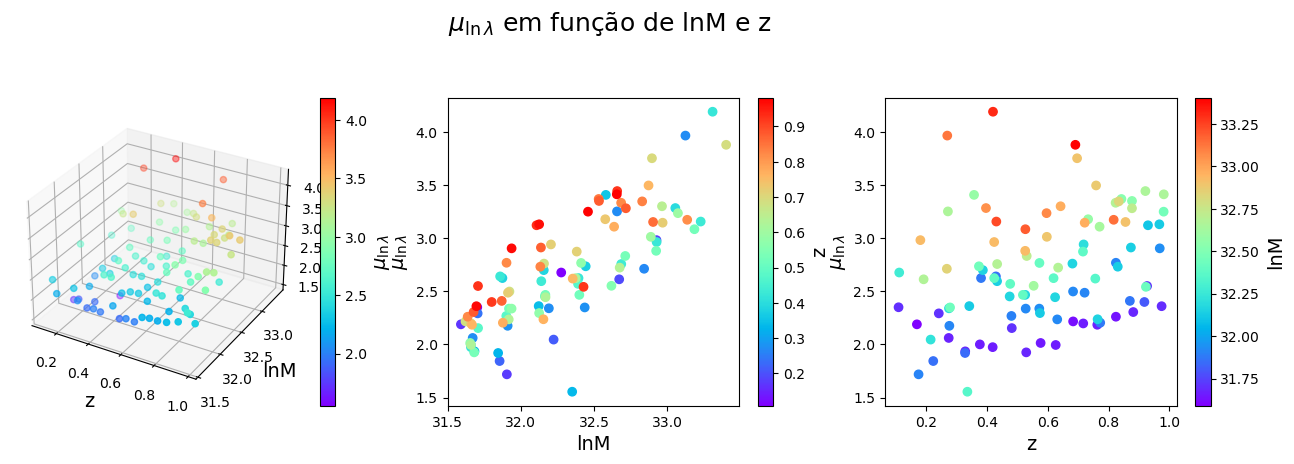

In [6]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

zs = lnR_mean # MÉDIA DE LN(R)
xs = z_mean # MÉDIA DE Z
ys = lnM_mean # MÉDIA DE LN(M)

p3 =ax1.scatter(xs, ys, zs, c=zs, cmap='rainbow')
ax1.set_xlabel('z', fontsize = 14)
ax1.set_ylabel('lnM', fontsize = 14)
fig.colorbar(p3, ax=ax1).set_label(label='$ \mu_{\ln \lambda} $',size=14)

p4 = ax2.scatter(ys, zs , c= xs, cmap='rainbow')
ax2.set_xlabel('lnM', fontsize = 14)
ax2.set_ylabel('$ \mu_{\ln \lambda} $', fontsize = 14)

fig.colorbar(p4, ax=ax2).set_label(label='z',size=14)


p5 = ax3.scatter(xs, zs , c=ys, cmap='rainbow') 
ax3.set_xlabel('z', fontsize = 14)
ax3.set_ylabel('$ \mu_{\ln \lambda} $',  fontsize = 14)
fig.colorbar(p5, ax=ax3).set_label(label='lnM',size=14)


fig.suptitle('$ \mu_{\ln \lambda} $ em função de lnM e z ', size = 18, y=1.10)

plt.show()

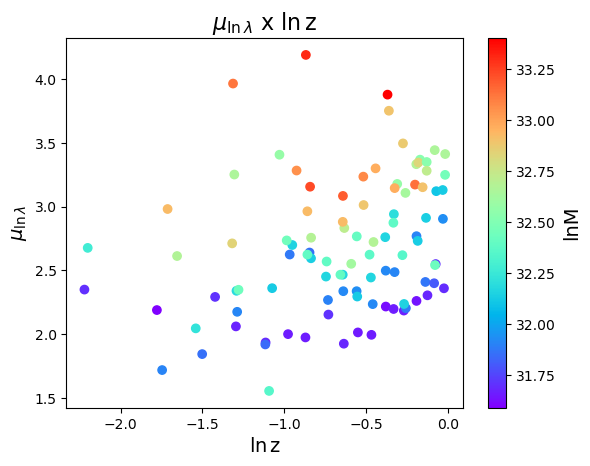

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

lnz = np.log(np.array(z_mean)) # LN (MÉDIA DE Z)

lnzp = ax.scatter(lnz, zs , c=ys, cmap='rainbow') 
ax.set_xlabel('$\ln$z', fontsize = 14)
ax.set_ylabel('$ \mu_{\ln \lambda} $',  fontsize = 14)
ax.set_title("$\mu_{\ln \lambda} $ x $\ln$z ", fontsize=16)
fig.colorbar(lnzp, ax=ax).set_label(label='lnM',size=14)

plt.show()

## Models fit

In [8]:
def Model_fit(mod):
    dt_halos = protoDC2_v3_redmapper
    rmdata = create_richness_mass_calib(dt_halos)
    fixed_parameters = []
    
    match mod:
        case "ext_ln1pz":
            model = Nc.ClusterMassLnrichExt()
            #model.get_property('use_ln1pz') ???
            fixed_parameters = [12, 13, 14] #fixing cut parameters
            
        case "ext_z":
            model = Nc.ClusterMassLnrichExt()
            fixed_parameters = [12, 13, 14] #fixing cut parameters
            
        case "ascaso":
            model = Nc.ClusterMassAscaso()
            fixed_parameters = [6] #fixing cut parameter
    
    #Model
    model.param_set_by_name("cut", 1e15) #Set cut parameter value 
    mset = Ncm.MSet()
    mset.set(model)
    rmdata.m2lnL_val(mset)  
    mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free
    
    #Data
    dset = Ncm.Dataset.new()
    dset.append_data(rmdata)
    
    #Likelihood
    lh = Ncm.Likelihood.new(dset)

    
    #All parameters free except cut parameters:
    for par in fixed_parameters:
        mset.param_set_ftype(7000, par, Ncm.ParamType.FIXED)
    
    mset.prepare_fparam_map()
    
    #Fit
    fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
    fit.log_info()
    fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    fit.log_info()
    
    lnR_mean_model = np.array([model.get_mean_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])
    lnR_std_model = np.array( [model.get_std_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])
    
    return lnR_mean_model, lnR_std_model, model



## Ascaso Fit Params

Aqui fazemos o ajuste do modelo de ascaso e encontramos os valores dos parâmetros usando todos os dados em **dt_halos** (sem dividir em intervalos). 

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$



In [9]:
lnR_mean_ascaso, lnR_std_ascaso, ascaso = Model_fit('ascaso')

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1e+15               [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#
#  Minimum found with precision: |df|/f =  0.00000e+00 

/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/richness_mass_calib.py:33: RuntimeWarning: invalid value encountered in log
  rich_v.set(i, np.log(rich))

(process:2290131): NUMCOSMO-WARNING **: 05:37:26.524: ncm_fit_run: initial point provides m2lnL =                   -nan, giving up.


## Ext (ln(1+z)) Fit Params

Aqui fazemos o ajuste do modelo extendido considerando a dependencia em $\ln (1 + z)$, também usando todos os dados em **dt_halos** .

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [10]:
lnR_mean_ext_ln1pz, lnR_std_ext_ln1pz, ext_ln1pz = Model_fit('ext_ln1pz')

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -     cut[12]:  1e+15               [FIX


(process:2290131): NUMCOSMO-WARNING **: 05:37:26.551: ncm_fit_run: initial point provides m2lnL =                   -nan, giving up.


## Ext (z) Fit Params


Aqui consideramos o ajuste do modelo extendido considerando a dependência em $ z$, também usando todos os dados em **dt_halos** .

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \left(\frac{ z}{z_0}\right) +
    \mu_{z2} \left(\frac{z}{z_0}\right)^2 +
    \mu_{Mz} \left(\frac{z}{z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [11]:
lnR_mean_ext_z, lnR_std_ext_z, ext_z = Model_fit('ext_z')

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -     cut[12]:  1e+15               [FIX


(process:2290131): NUMCOSMO-WARNING **: 05:37:26.581: ncm_fit_run: initial point provides m2lnL =                   -nan, giving up.


## Comparison I

In [12]:
def Plot_model(lnR_mean_model):

    fig = plt.figure(figsize=(16,4))

    ax1 = fig.add_subplot(1,3,1, projection='3d')
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    #lnR model, z_mean, y_mean
    xs = z_mean
    ys = lnM_mean
    zs = lnR_mean_model
    
    p1 =ax1.scatter(xs, ys, zs, c=zs, cmap='cool')
    ax1.set_xlabel('z')
    ax1.set_ylabel('lnM')
    fig.colorbar(p1, ax=ax1, label='<LnR| M, z>')

    ax2.scatter(lnM_mean, lnR_mean, c='k', label='lnR médio')
    p2 = ax2.scatter(ys, zs , c= xs, cmap='cool')
    ax2.set_xlabel('lnM')
    ax2.set_ylabel('<LnR| M, z>')
    fig.colorbar(p2, ax=ax2, label='z')
    ax2.legend()

    ax3.scatter(z_mean, lnR_mean, c='k', label='lnR médio')
    p3 = ax3.scatter(xs, zs , c=ys, cmap='cool') 
    ax3.set_xlabel('z')
    ax3.set_ylabel('<LnR| M, z>')
    fig.colorbar(p3, ax=ax3, label='lnM')
    ax3.legend()

    
    if f'{lnR_mean_model}' == f'{lnR_mean_ascaso}': 
        fig.suptitle('Modelo de Ascaso')
    elif f'{lnR_mean_model}' == f'{lnR_mean_ext_ln1pz}': 
        fig.suptitle('Modelo Estendido (ln(1 + z)) ')
    elif f'{lnR_mean_model}' == f'{lnR_mean_ext_z}': 
        fig.suptitle('Modelo Estendido (z)')
    else: 
        fig.suptitle('Is this other model?')
        
    plt.show()


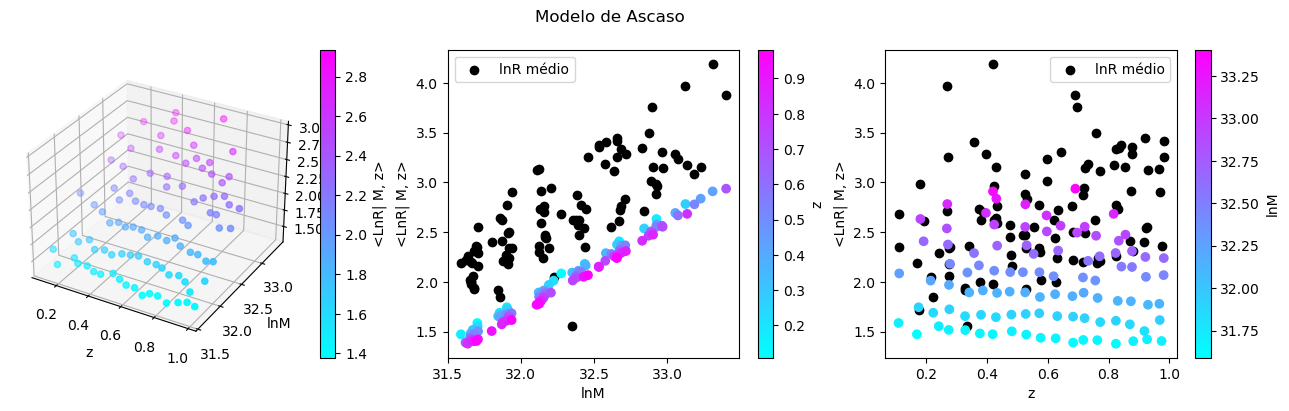

In [13]:
Plot_model(lnR_mean_ascaso) #Ascaso

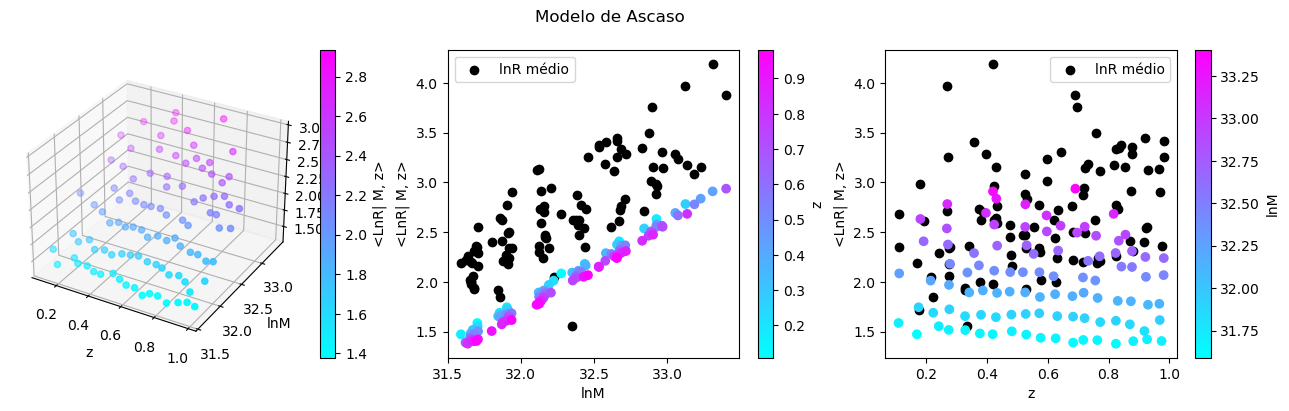

In [14]:
Plot_model(lnR_mean_ext_ln1pz) #Extended (ln(1 + z)) 

## Comparison II

/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


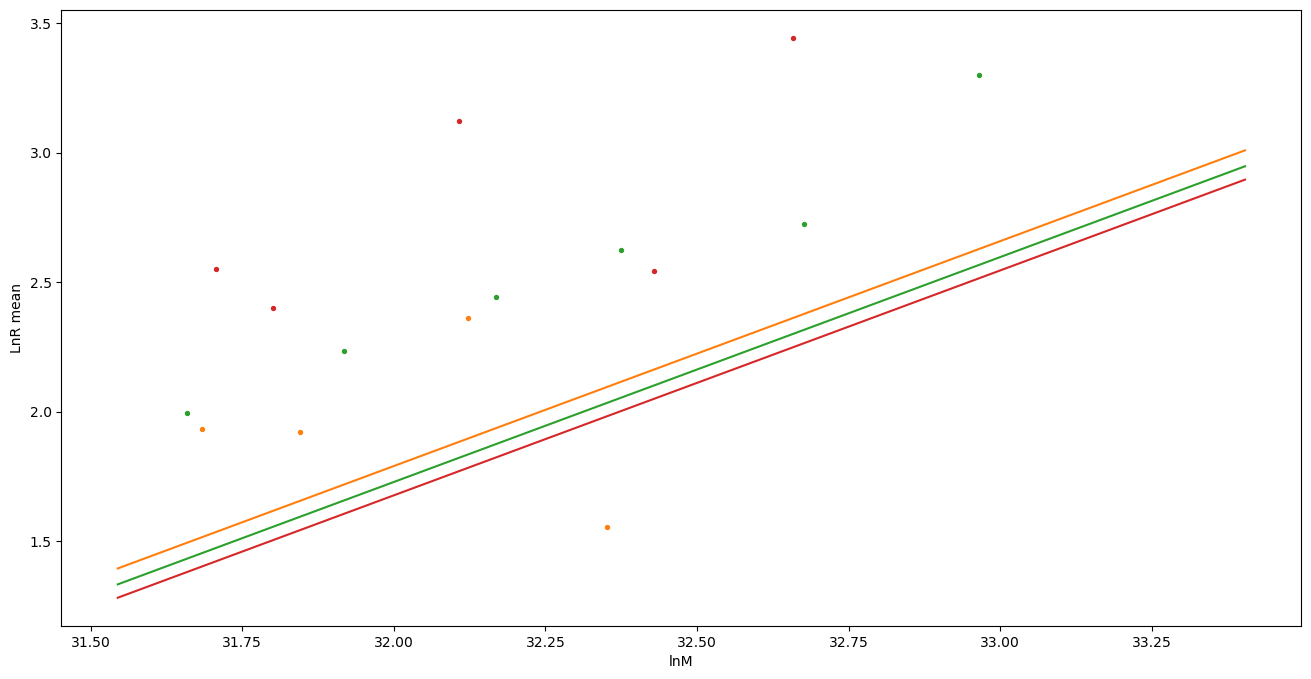

In [15]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,1,1)

zs = lnR_mean_ext_ln1pz
xs = z
ys = lnM

z_a = np.linspace(np.min(z), np.max(z), 6)
lnM_a = np.linspace(np.min(lnM), np.max(lnM), 1000)

for j in range(0, 61, 6):
    z_j = np.mean(z_binned[j * 21])
    
    ax.plot(lnM_a, [ext_ln1pz.get_mean_richness(lnM_i, z_j) for lnM_i in lnM_a])
    t1 = [np.mean(lnM_binned[j * 21 + i ]) for i in range(21)]
    t2 = [np.mean(lnR_binned[j * 21 + i ]) for i in range(21)]
    
    ax.scatter(t1, t2, s=8)
    
ax.set_xlabel('lnM')
ax.set_ylabel('LnR mean')

plt.show()


## Comparison III

/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


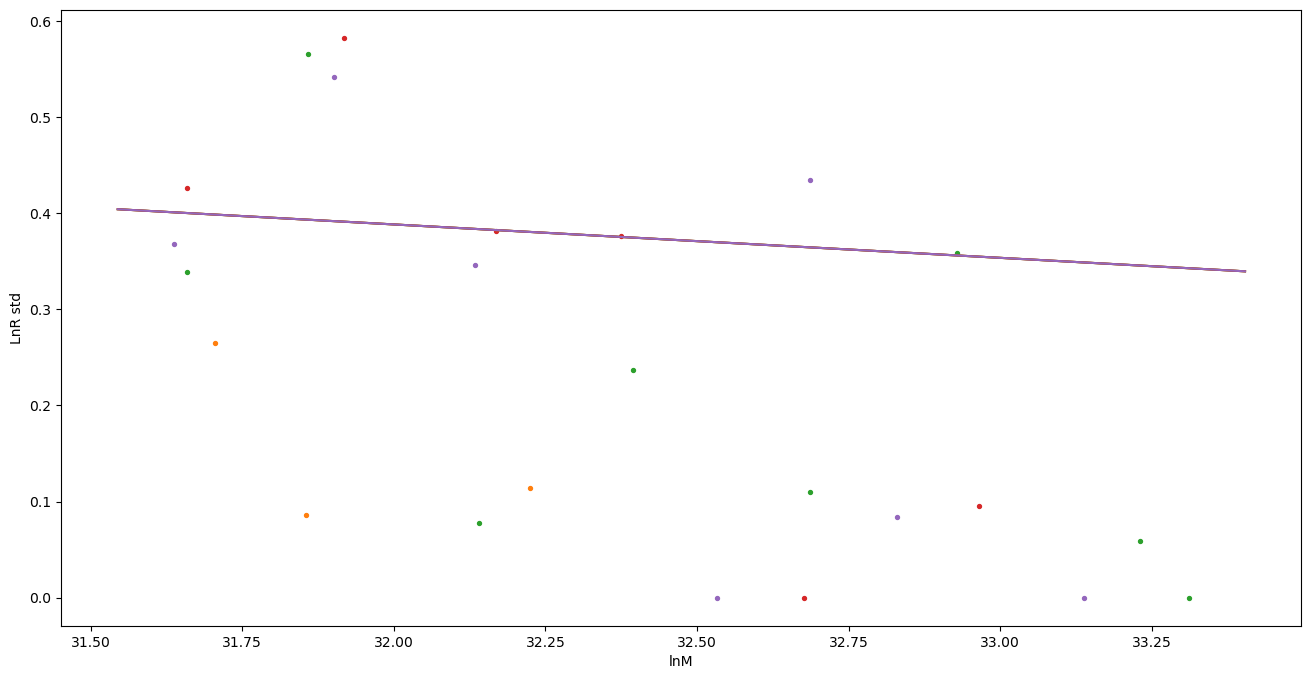

In [16]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,1,1)

z_a = np.linspace(np.min(z), np.max(z), 4)
lnM_a = np.linspace(np.min(lnM), np.max(lnM), 1000)

for j in range(0, 60, 4):
    z_j = np.mean(z_binned[j * 21])
    
    ax.plot(lnM_a, [ext_ln1pz.get_std_richness(lnM_i, z_j) for lnM_i in lnM_a])
    t1 = [np.mean(lnM_binned[j * 21 + i ]) for i in range(21)]
    t2 = [np.std(lnR_binned[j * 21 + i ]) for i in range(21)]
    
    ax.scatter(t1, t2, s=8)
    #ax.plot(t1, t2)

ax.set_xlabel('lnM')
ax.set_ylabel('LnR std')

plt.show()
